# Navie-Bayes on our dataset

***

**Description**
In this document we prepare our code for the Naive Bayes algorithm and we runit. Then we discuss its accuracy.





***

The first step is loading the libraries and importing the dataset


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.contingency_tables import mcnemar

from imblearn.over_sampling import RandomOverSampler

# Load the datasets
df = pd.read_csv('preprocessed.csv')
dfn = pd.read_csv('preprocessed_encoded.csv')

# Ensure that all missing values are handled appropriately
numerical_columns = dfn.select_dtypes(include=[np.number]).columns
categorical_columns = dfn.select_dtypes(include=['object']).columns

dfn[numerical_columns] = dfn[numerical_columns].fillna(dfn[numerical_columns].mean())
for column in categorical_columns:
    dfn[column].fillna(dfn[column].mode()[0], inplace=True)

# Exclude the decision columns from features
X = dfn
y = df['match']


# Split the dataset in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalization of the data starting from information of just the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply the scaler to the test set
X_test = scaler.transform(X_test)

# Oversample the data to have a more balanced dataset
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)





In [2]:


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9796, 332)
(2514, 332)
(9796,)
(2514,)


In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize Gaussian Naive Bayes
gnb = GaussianNB()

# Perform cross-validation
cv = StratifiedKFold(n_splits=20)
cv_scores = cross_val_score(gnb, X_train, y_train, cv=cv)
mean_cv_score = np.mean(cv_scores)
print(f"Mean CV score: {mean_cv_score}")

Mean CV score: 0.5738066023955595


Apply a K fold 
Try encoding it in a different way to see if the change is different. 


In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Predict on the test set
gnb.fit(X_train, y_train)
predicted = gnb.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted))
print("Accuracy Score:")
print(accuracy_score(y_test, predicted))
print("Classification Report:")
print(classification_report(y_test, predicted))

Confusion Matrix:
[[ 314 1786]
 [  37  377]]
Accuracy Score:
0.2748607796340493
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.15      0.26      2100
           1       0.17      0.91      0.29       414

    accuracy                           0.27      2514
   macro avg       0.53      0.53      0.27      2514
weighted avg       0.78      0.27      0.26      2514


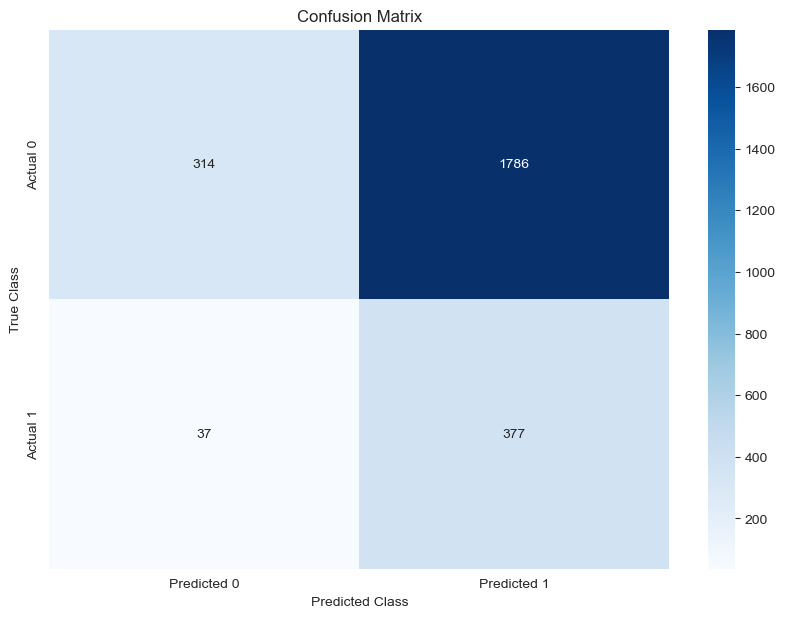

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
cm = confusion_matrix(y_test, predicted)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

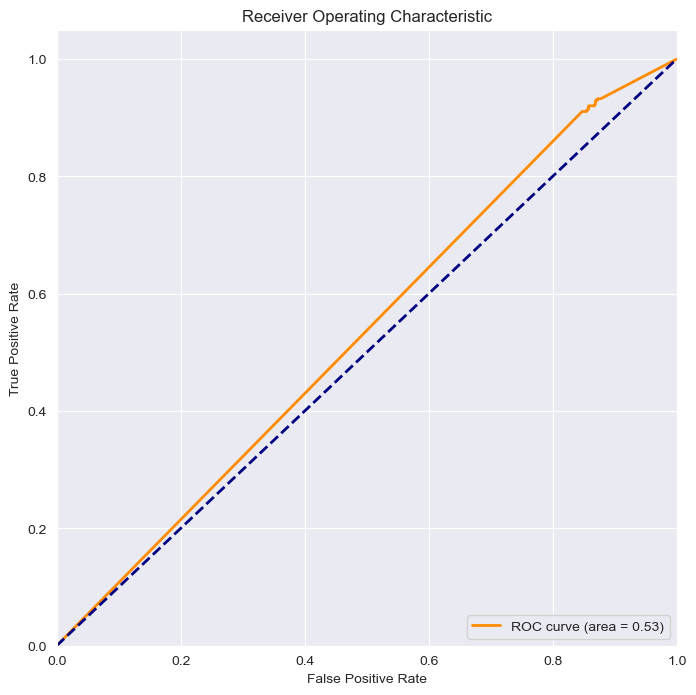

In [6]:
from sklearn.metrics import roc_curve, auc

# Calcular las métricas para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


              precision    recall  f1-score      support
0              0.894587  0.149524  0.256222  2100.000000
1              0.174295  0.910628  0.292588   414.000000
accuracy       0.274861  0.274861  0.274861     0.274861
macro avg      0.534441  0.530076  0.274405  2514.000000
weighted avg   0.775971  0.274861  0.262211  2514.000000


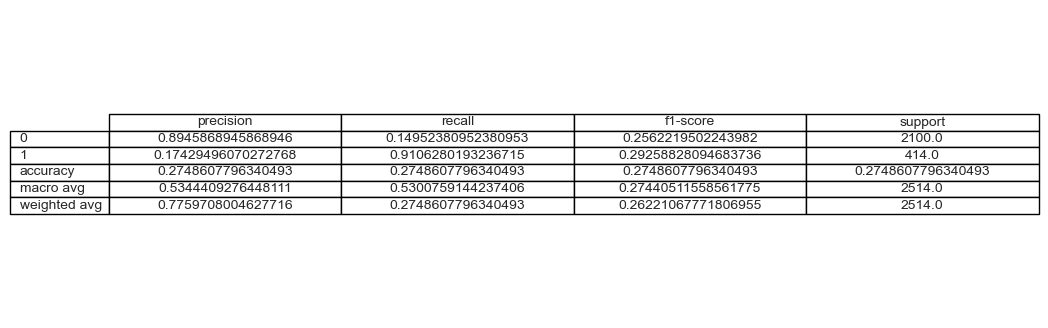

In [7]:
from sklearn.metrics import classification_report
import pandas as pdf

# Generar reporte de clasificación
report = classification_report(y_test, predicted, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Visualizar el reporte de clasificación
print(df_report)

# Opcional: guardar el dataframe como imagen si prefieres
fig, ax = plt.subplots(figsize=(12, 4))  # Tamaño del 'canvas'
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_report.values, colLabels=df_report.columns, rowLabels=df_report.index, loc='center', cellLoc='center')
plt.show()



In [11]:
accuracy = accuracy_score(y_test, predicted)

print(proportion_confint(accuracy * X_test.shape[0], X_test.shape[0], alpha=0.05, method='normal'))
print("Interval 95% confidence:", "{0:.3f}".format(accuracy), "+/-", "{0:.3f}".format(1.96*np.sqrt(accuracy*(1-accuracy)/X_test.shape[0])))

(0.25740928857829914, 0.2923122706897995)
Interval 95% confidence: 0.275 +/- 0.017
